<a href="https://colab.research.google.com/github/jaysulk/ICML_Notebooks/blob/main/PINO_Heat_1D_HNO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [ ]:
!git clone -b HartleyTransform https://github.com/jaysulk/PINO_Applications

fatal: destination path 'PINO_Applications' already exists and is not an empty directory.


In [ ]:
%cd /content/drive/MyDrive/Github/PINO_Applications

/content/drive/MyDrive/Github/PINO_Applications


In [ ]:
!pip install functorch

In [ ]:
!pip install Mat73

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook
from argparse import ArgumentParser
import yaml
import os
import torch
# from torch import vmap
from functorch import vmap, grad

from models import FNN2d, FNN2d_AD
from train_utils import Adam
# from train_utils.datasets import BurgersLoader'
# from train_utils.train_2d import train_2d_burger
# from train_utils.eval_2d import eval_burgers

from solver.HeatEq import HeatEq1D
import traceback

import scipy.io
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import imageio



from tqdm import tqdm
from train_utils.utils import get_grid, save_checkpoint, torch2dgrid, load_checkpoint, load_config, update_config
from train_utils.losses import LpLoss
from train_utils.datasets import DataLoader1D
# from utils import torch2dgrid
from solver.my_random_fields import GRF_Mattern

from importlib import reload

try:
    import wandb
except ImportError:
    wandb = None
import pickle

In [ ]:
import torch
import numpy as np

def central_difference_second_order(tensor, axis=2, dx=1.0):
    return (tensor[:, 2:, :] - 2 * tensor[:, 1:-1, :] + tensor[:, :-2, :]) / (dx ** 2)

def FDM_Heat(u, D=1, alpha=0.01):
    batchsize = u.size(0)
    nt = u.size(1)
    nx = u.size(2)

    u = u.reshape(batchsize, nt, nx)
    dt = D / (nt - 1)
    dx = D / (nx)

    # Calculate the second spatial derivative using central difference
    uxx = central_difference_second_order(u, axis=2, dx=dx)

    # Calculate the first temporal derivative using central difference
    ut = (u[:, 2:, :] - u[:, :-2, :]) / (2 * dt)

    # Combine to get Du
    Du = ut + alpha * uxx

    return Du

def PINO_loss_Heat(u, u0, alpha=0.01):
    batchsize = u.size(0)
    nt = u.size(1)
    nx = u.size(2)

    u = u.reshape(batchsize, nt, nx)

    index_t = torch.zeros(nx,).long()
    index_x = torch.tensor(range(nx)).long()
    boundary_u = u[:, index_t, index_x]
    loss_u = F.mse_loss(boundary_u, u0)

    Du = FDM_Heat(u, alpha=alpha)[:, :, :]
    f = torch.zeros(Du.shape, device=u.device)
    loss_f = F.mse_loss(Du, f)

    return loss_u, loss_f

In [ ]:
def train_Heat(model,
                  train_loader,
                  optimizer,
                  scheduler,
                  config,
                  rank=0,
                  log=False,
                  project='PINO-2d-default',
                  group='default',
                  tags=['default'],
                  use_tqdm=True):
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    alpha = config['data']['alpha']
    ckpt_freq = config['train']['ckpt_freq']

    model.train()
    myloss = LpLoss(size_average=True)

    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        data_l2 = 0.0
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)

            loss_u, loss_f = PINO_loss_Heat(out, x[:, 0, :, 0], alpha=alpha)
            total_loss = loss_u * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_loss += total_loss.item()
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_loss /= len(train_loader)
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

In [ ]:
def eval_Heat(model,
                 dataloader,
                 config,
                 device,
                 use_tqdm=True):
    model.eval()
    myloss = LpLoss(size_average=True)
    alpha = config['data']['alpha']
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)

            loss_u, f_loss = PINO_loss_Heat(out, x[:, 0, :, 0], alpha=alpha)
            test_err.append(data_loss.item())
            f_err.append(f_loss.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')

In [ ]:
config_file = 'configs/custom/heat-0000.yaml'
config = load_config(config_file)
display(config)

{'data': {'name': 'Heat-0000',
  'total_num': 100,
  'n_train': 90,
  'n_test': 10,
  'nx': 128,
  'nt': 100,
  'sub': 1,
  'sub_t': 1,
  'alpha': 0.01},
 'model': {'layers': [16, 24, 24, 32, 32],
  'modes1': [15, 12, 9, 9],
  'modes2': [15, 12, 9, 9],
  'fc_dim': 128,
  'activation': 'gelu'},
 'train': {'batchsize': 20,
  'epochs': 500,
  'milestones': [100, 200, 300, 400, 500],
  'base_lr': 0.001,
  'scheduler_gamma': 0.5,
  'ic_loss': 5.0,
  'f_loss': 1.0,
  'xy_loss': 5.0,
  'save_dir': 'Heat',
  'save_name': 'Heat-0000.pt',
  'ckpt': 'checkpoints/Heat/Heat-0000.pt',
  'ckpt_freq': 100},
 'log': {'project': 'PINO-Heat', 'group': 'Heat-0000'},
 'test': {'batchsize': 1, 'ckpt': 'checkpoints/Heat/Heat-0000.pt'}}

In [ ]:
Nsamples = config['data']['total_num']
N = config['data']['nx']
Nt0 = config['data']['nt']
alpha = config['data']['alpha']
sub_x = config['data']['sub']
sub_t = config['data']['sub_t']
Nx = N // sub_x
Nt = Nt0 // sub_t + 1
dim = 1
l = 0.5
L = 1.0
sigma = 1 #2.0
Nu = None # 2.0
dt = 1.0e-4
tend = 1.0
save_int = int(tend/dt/Nt)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
#grf = GRF_Mattern(dim, N, length=L, nu=Nu, l=l, sigma=sigma, boundary="periodic", device=device)
#U0 = grf.sample(Nsamples)

In [ ]:
#with open('../../T0.pkl', 'wb') as f:
#  pickle.dump(U0, f)

In [ ]:
with open('../../T0.pkl', 'rb') as f:
  U0 = pickle.load(f)

In [ ]:
U0.shape

torch.Size([100, 128])

In [ ]:
alpha

0.01

In [ ]:
heat_eq = HeatEq1D(Nx=Nx, alpha=alpha, dt=dt, device=device)
save_interval = int(1e-2/dt)
U = vmap(heat_eq.heat_driver, in_dims=(0, None))(U0, save_interval)

In [ ]:
a = U0.cpu().float()
u = U.cpu().float()
display(u.shape,a.shape)

torch.Size([100, 101, 128])

torch.Size([100, 128])

In [ ]:
dataset = DataLoader1D(a, u, config['data']['nx'], config['data']['nt'])
train_loader = dataset.make_loader(config['data']['n_train'], config['train']['batchsize'], start=0, train=True)
test_loader = dataset.make_loader(config['data']['n_test'], config['test']['batchsize'], start=config['data']['n_train'], train=False)

In [ ]:
model = FNN2d(modes1=config['model']['modes1'],
              modes2=config['model']['modes2'],
              fc_dim=config['model']['fc_dim'],
              layers=config['model']['layers'],
              activation=config['model']['activation'],
             ).to(device)

In [ ]:
log = False

optimizer = Adam(model.parameters(), betas=(0.9, 0.999),lr=config['train']['base_lr'])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=config['train']['milestones'],
                                                 gamma=config['train']['scheduler_gamma'])

In [ ]:
#load_checkpoint(model,

In [ ]:
from timeit import default_timer as timer
from datetime import timedelta
start = timer()
train_Heat(model,
              train_loader,
              optimizer,
              scheduler,
              config,
              rank=0,
              log=log,
              project=config['log']['project'],
              group=config['log']['group'])
end = timer()
print(timedelta(seconds=end-start))

Epoch 0, train loss: 5.21030 train f error: 0.00000; data l2 error: 1.01960:   0%|          | 1/500 [00:00<03:31,  2.36it/s]

Checkpoint is saved at checkpoints/Heat/Heat-0000_0.pt


Epoch 100, train loss: 0.29370 train f error: 0.00207; data l2 error: 0.05828:  20%|██        | 101/500 [00:37<02:30,  2.65it/s]

Checkpoint is saved at checkpoints/Heat/Heat-0000_100.pt


Epoch 200, train loss: 0.07192 train f error: 0.00223; data l2 error: 0.01393:  40%|████      | 201/500 [01:15<01:57,  2.55it/s]

Checkpoint is saved at checkpoints/Heat/Heat-0000_200.pt


Epoch 300, train loss: 0.04987 train f error: 0.00222; data l2 error: 0.00952:  60%|██████    | 301/500 [01:51<01:13,  2.69it/s]

Checkpoint is saved at checkpoints/Heat/Heat-0000_300.pt


Epoch 400, train loss: 0.03165 train f error: 0.00233; data l2 error: 0.00586:  80%|████████  | 401/500 [02:28<00:36,  2.70it/s]

Checkpoint is saved at checkpoints/Heat/Heat-0000_400.pt


Epoch 499, train loss: 0.02892 train f error: 0.00231; data l2 error: 0.00532: 100%|██████████| 500/500 [03:04<00:00,  2.70it/s]

Checkpoint is saved at checkpoints/Heat/Heat-0000.pt
Done!
0:03:04.959367


In [ ]:
eval_Heat(model, test_loader, config, device)

100%|██████████| 10/10 [00:00<00:00, 178.43it/s]

==Averaged relative L2 error mean: 0.005554345855489373, std error: 0.00018285158188143278==
==Averaged equation error mean: 0.002143888422870077, std error: 0.00045971346119376617==


In [ ]:
Nx = config['data']['nx']
Nt = config['data']['nt'] + 1
N = config['data']['n_test']
model.eval()
test_x = np.zeros((N,Nt,Nx,3))
preds_y = np.zeros((N,Nt,Nx))
test_y = np.zeros((N,Nt,Nx))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [ ]:
Nx = config['data']['nx']
Nt = config['data']['nt'] + 1
N = config['data']['n_test']
model.eval()
test_x = np.zeros((N,Nt,Nx,3))
preds_y = np.zeros((N,Nt,Nx))
test_y = np.zeros((N,Nt,Nx))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [ ]:
data_x.shape

torch.Size([1, 101, 128, 3])

In [ ]:
use_train_data = False
padding = 5
batch_size = config['test']['batchsize']
Nx = config['data']['nx']
# Ny = config['data']['nx']
Nt = config['data']['nt'] + 1
Ntest = config['data']['n_test']
Ntrain = config['data']['n_train']
loader = test_loader
if use_train_data:
    Ntest = Ntrain
    loader = train_loader
# in_dim = config['model']['in_dim']
# out_dim = config['model']['out_dim']

model.eval()
# model.to('cpu')
test_x = np.zeros((Ntest,Nt,Nx,3))
preds_y = np.zeros((Ntest,Nt,Nx))
test_y = np.zeros((Ntest,Nt,Nx))


with torch.no_grad():
    for i, data in enumerate(loader):
#     for i, data in enumerate(train_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
#         data_x_pad = F.pad()
#         display(data_x.shape)
        data_x_pad = F.pad(data_x, (0, 0, 0, 0, 0, padding), "constant", 0)
        pred_y_pad = model(data_x_pad).reshape(batch_size, Nt + padding, Nx)
#         out = out[..., :-padding, :]
#         pred_y_pad = model(data_x_pad).reshape(batch_size, Nx, Ny, Nt + padding, out_dim)
        pred_y = pred_y_pad[..., :-padding, :].reshape(data_y.shape)
#         pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
#         test_y0[i] = data_x[..., 0, -out_dim:].cpu().numpy() # same way as in training code
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [ ]:
len(preds_y)

10

In [ ]:
key = 0
pred = preds_y[key]
true = test_y[key]


a = test_x[key]
Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]

In [ ]:
fig = plt.figure(figsize=(24,5))
plt.subplot(1,4,1)

plt.plot(x, u0)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Intial Condition $u(x)$')
plt.xlim([0,1])
plt.tight_layout()

plt.subplot(1,4,2)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title(f'Exact $s(x,t)$')
plt.tight_layout()
plt.axis('square')

plt.subplot(1,4,3)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title(f'Predict $s(x,t)$')
plt.axis('square')

plt.tight_layout()

plt.subplot(1,4,4)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, pred - true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.axis('square')

# plt.show()

<IPython.core.display.Javascript object>

(0.0, 1.0, 0.0, 1.0)

In [ ]:
def save_data(data_path, test_x, test_y, preds_y):
    data_dir, data_filename = os.path.split(data_path)
    os.makedirs(data_dir, exist_ok=True)
    np.savez(data_path, test_x=test_x, test_y=test_y, preds_y=preds_y)

def load_data(data_path):
    data = np.load(data_path)
    test_x = data['test_x']
    test_y = data['test_y']
    preds_y = data['preds_y']
    return test_x, test_y, preds_y

In [ ]:
data_dir = 'data/Heat1D'
data_filename = 'data.npz'
data_path = os.path.join(data_dir, data_filename)
# os.makedirs(data_dir, exist_ok=True)


In [ ]:
save_data(data_path, test_x, test_y, preds_y)

In [ ]:
test_x, test_y, preds_y = load_data(data_path)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

def plot_predictions(key, test_x, test_y, preds_y, print_index=False, save_path=None, font_size=None):
    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
    pred = preds_y[key]
    true = test_y[key]

    a = test_x[key]
    Nt, Nx, _ = a.shape
    u0 = a[0,:,0]
    T = a[:,:,2]
    X = a[:,:,1]
    x = X[0]

    # Plot
    fig = plt.figure(figsize=(23,5))

    # Intial Condition
    plt.subplot(1,4,1)
    plt.plot(x, u0)
    plt.xlabel('$x$')
    plt.ylabel('$u$')
    plt.title('Intial Condition $u(x)$')
    plt.xlim([0,1])
    plt.ylim([-0.6,0.6])
    plt.text(0.05, 0.9, 'a', transform=plt.gca().transAxes)
    plt.tight_layout()

    # Exact
    plt.subplot(1,4,2)
    plt.pcolormesh(X, T, true, cmap='bwr', shading='gouraud')
    cbar = plt.colorbar()
    cbar.mappable.set_clim(-0.6, 0.6)
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title(f'Exact $u(x,t)$')
    plt.axis('square')
    plt.text(0.05, 0.9, 'b', transform=plt.gca().transAxes)
    plt.tight_layout()

    # Predict
    plt.subplot(1,4,3)
    plt.pcolormesh(X, T, pred, cmap='bwr', shading='gouraud')
    cbar = plt.colorbar()
    cbar.mappable.set_clim(-0.6, 0.6)
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title(f'Predict $u(x,t)$')
    plt.axis('square')
    plt.text(0.05, 0.9, 'c', transform=plt.gca().transAxes)
    plt.tight_layout()

    # Absolute Error
    my_object = np.abs(pred - true)
    plt.subplot(1,4,4)
    plt.pcolormesh(X, T, my_object, cmap='hot', shading='gouraud')
    cbar = plt.colorbar()
    cbar.mappable.set_clim(0, 0.1)
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title('Absolute Error')
    plt.axis('square')
    plt.text(0.05, 0.9, 'd', color='white', transform=plt.gca().transAxes)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(f'{save_path}.png', bbox_inches='tight')
        with open(f'{save_path}.pkl', 'wb') as f:
            pickle.dump(my_object, f)

    plt.show()


<IPython.core.display.Javascript object>

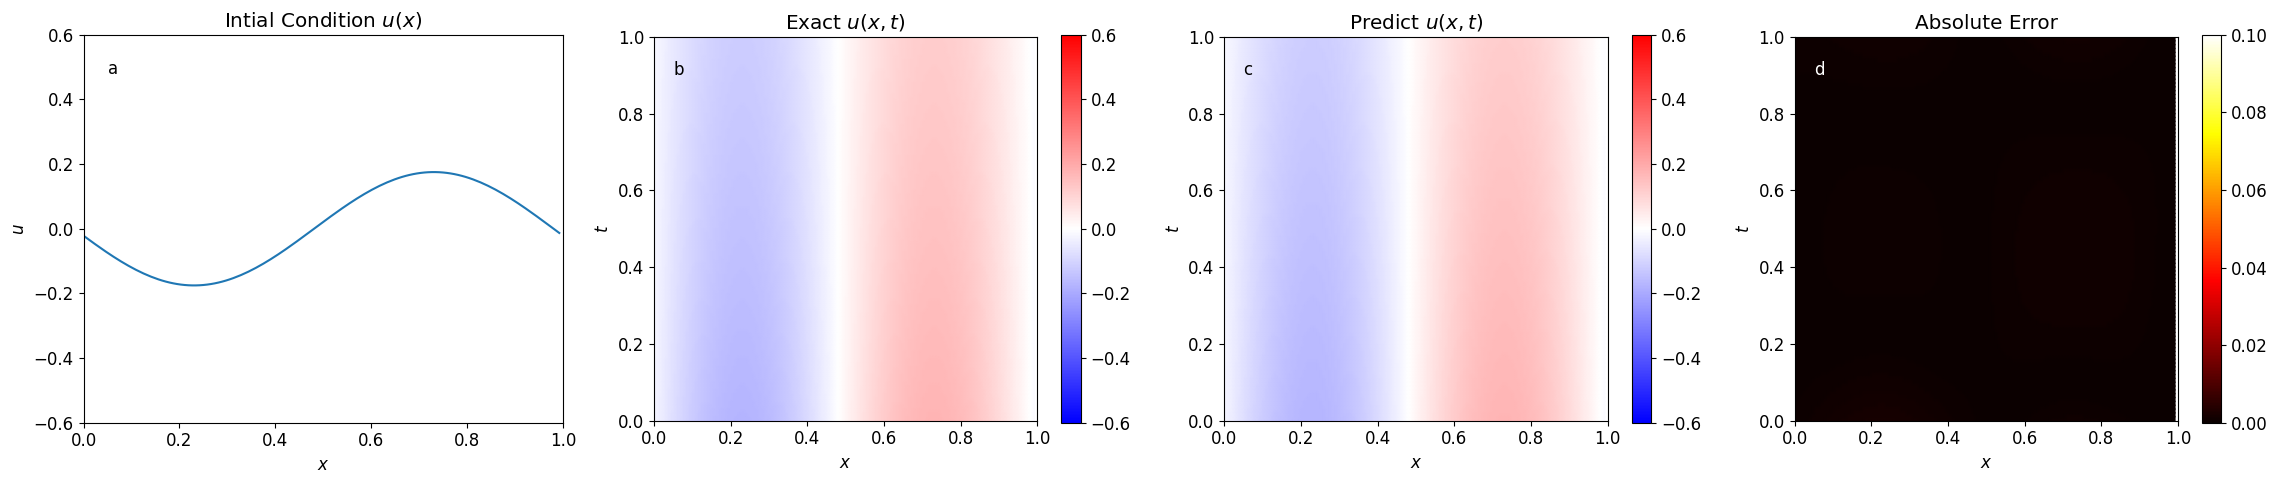

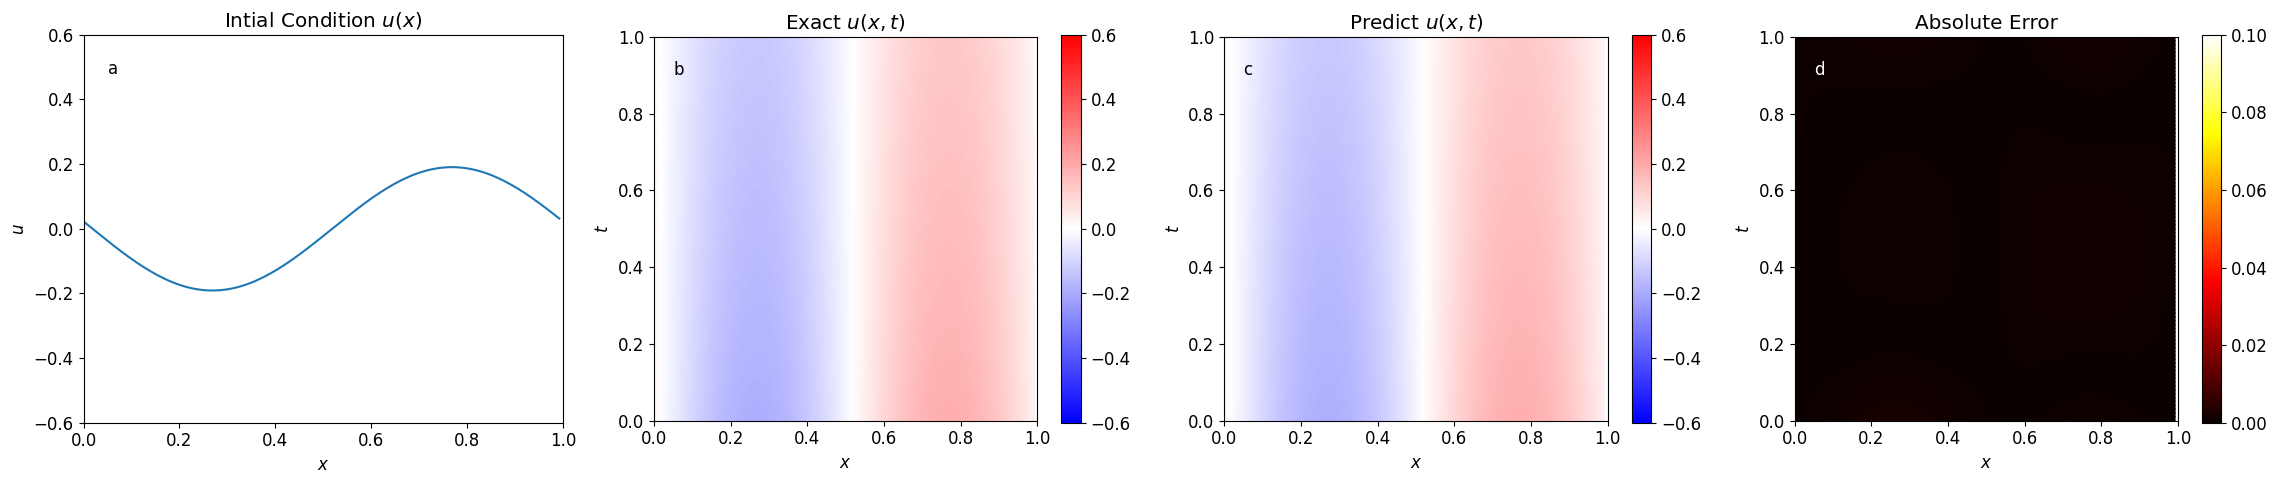

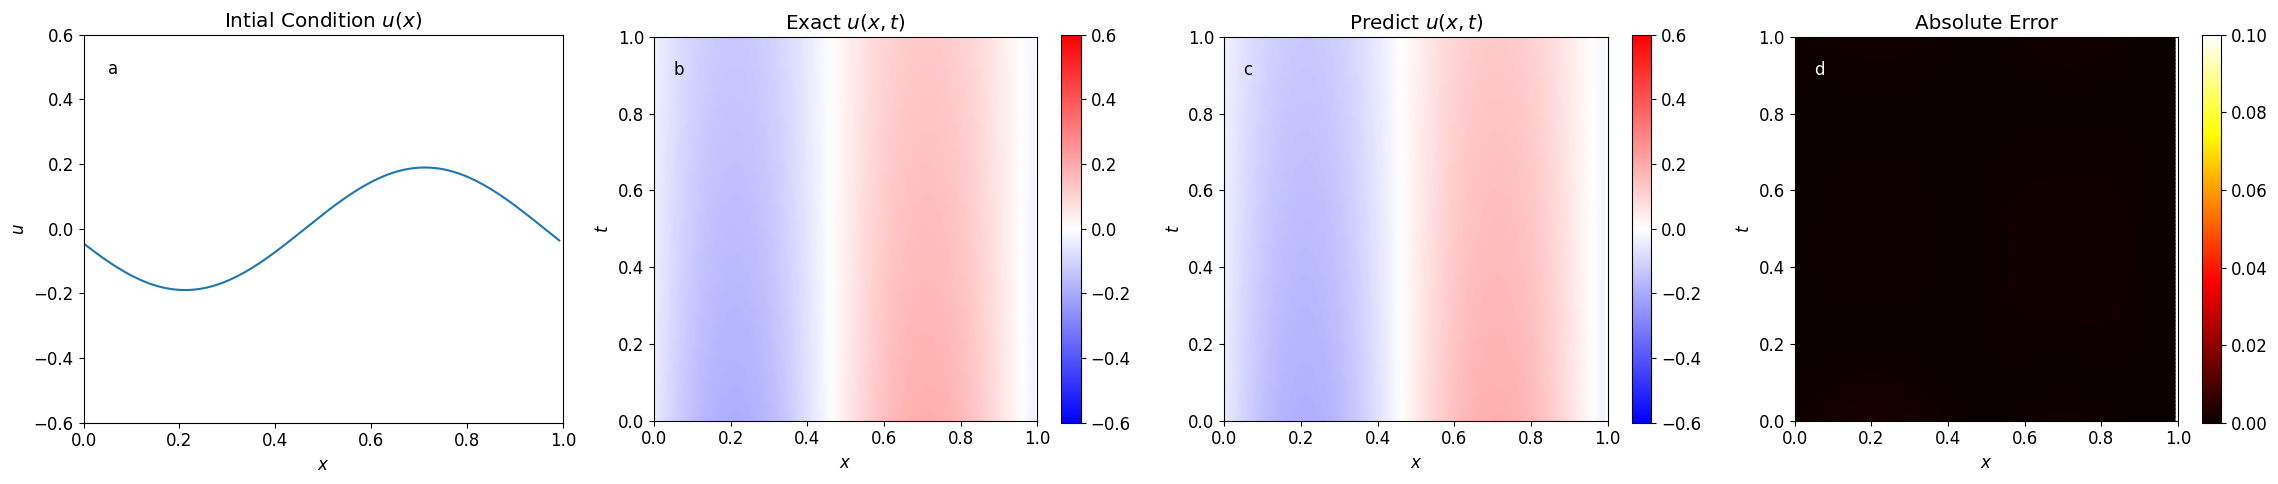

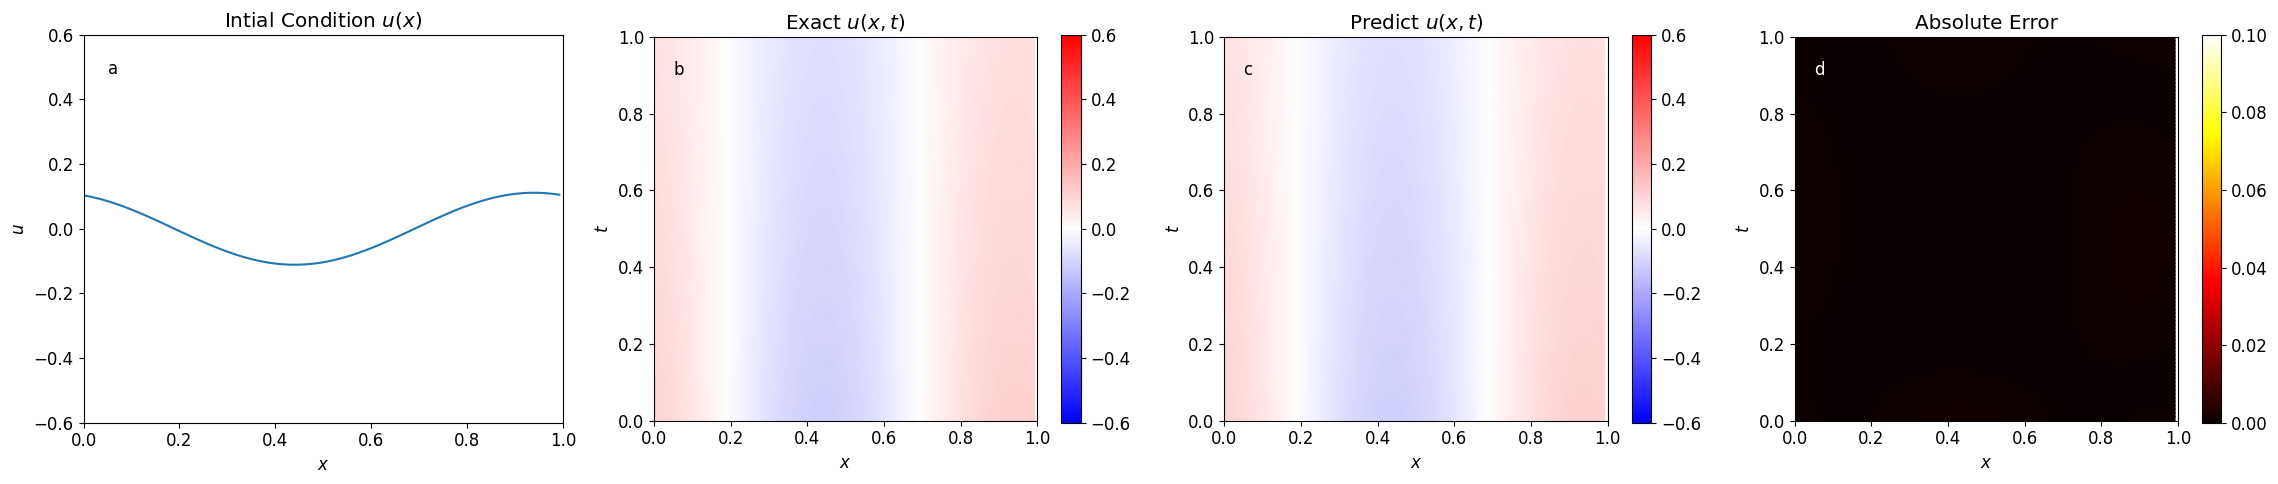

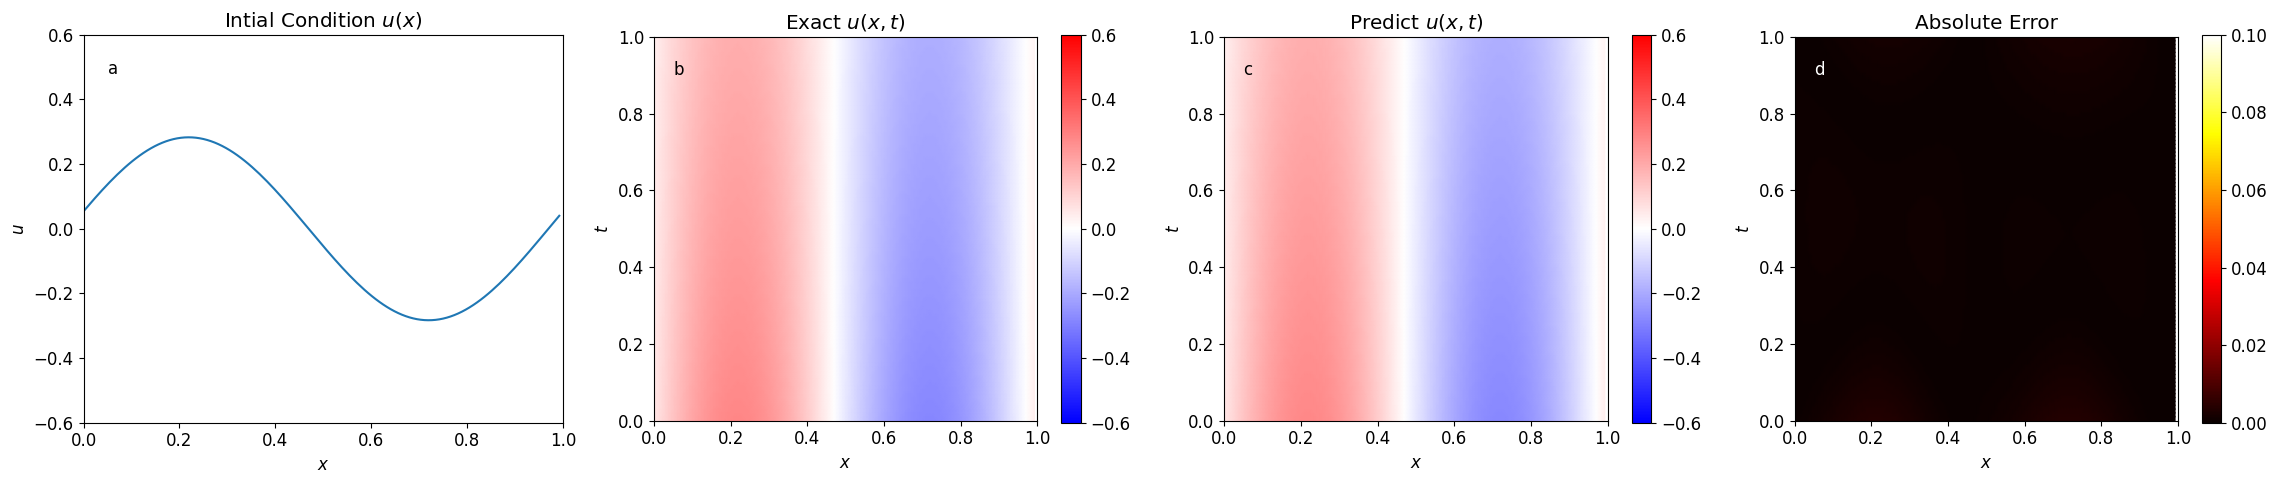

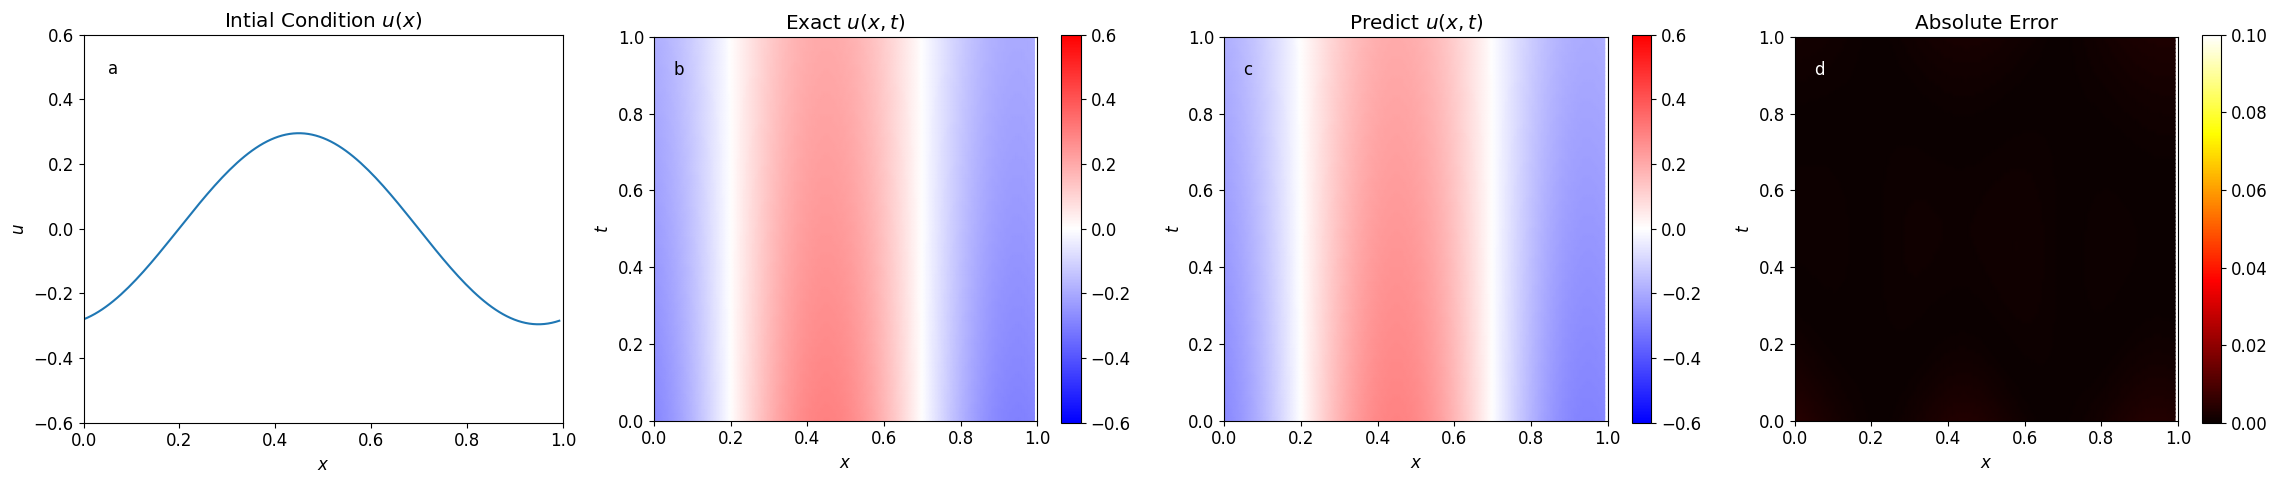

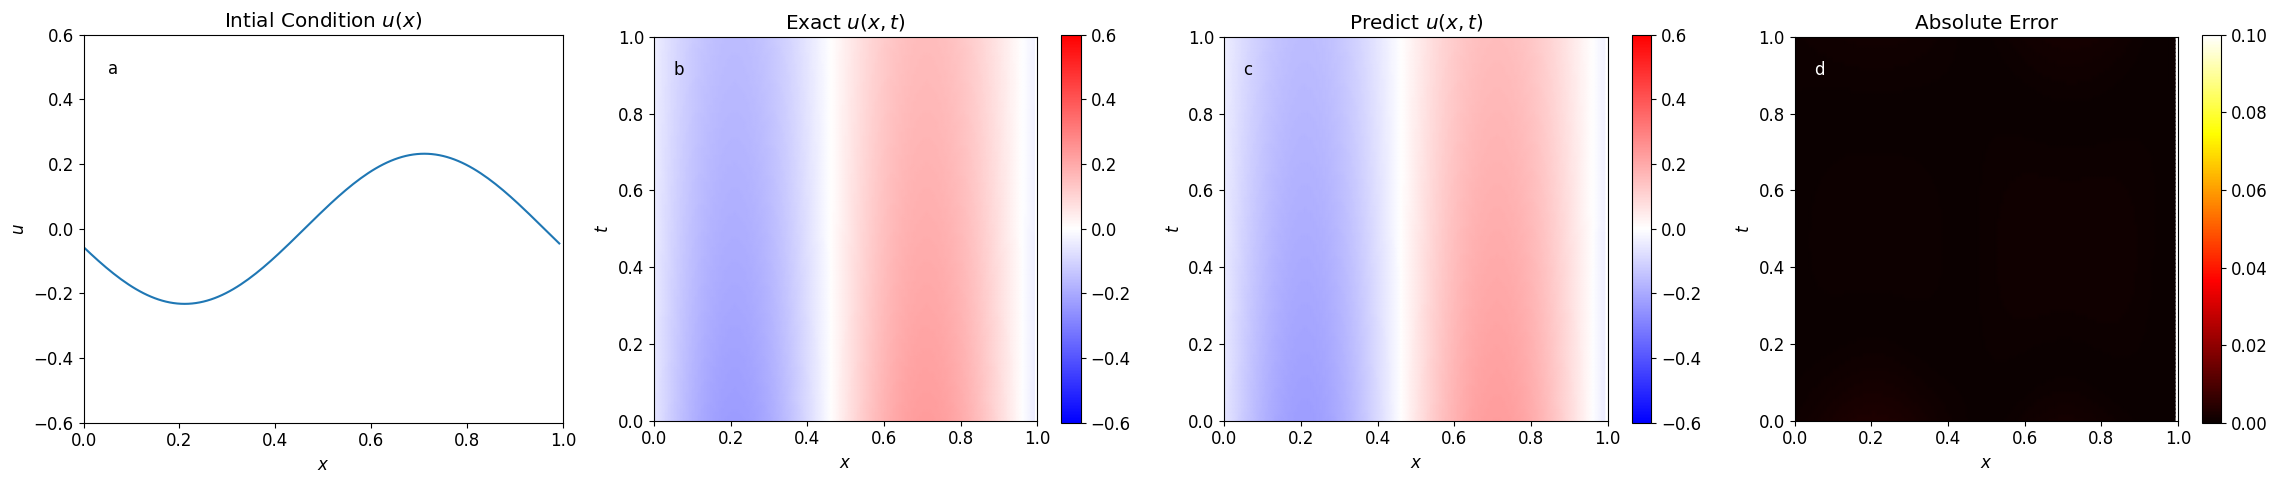

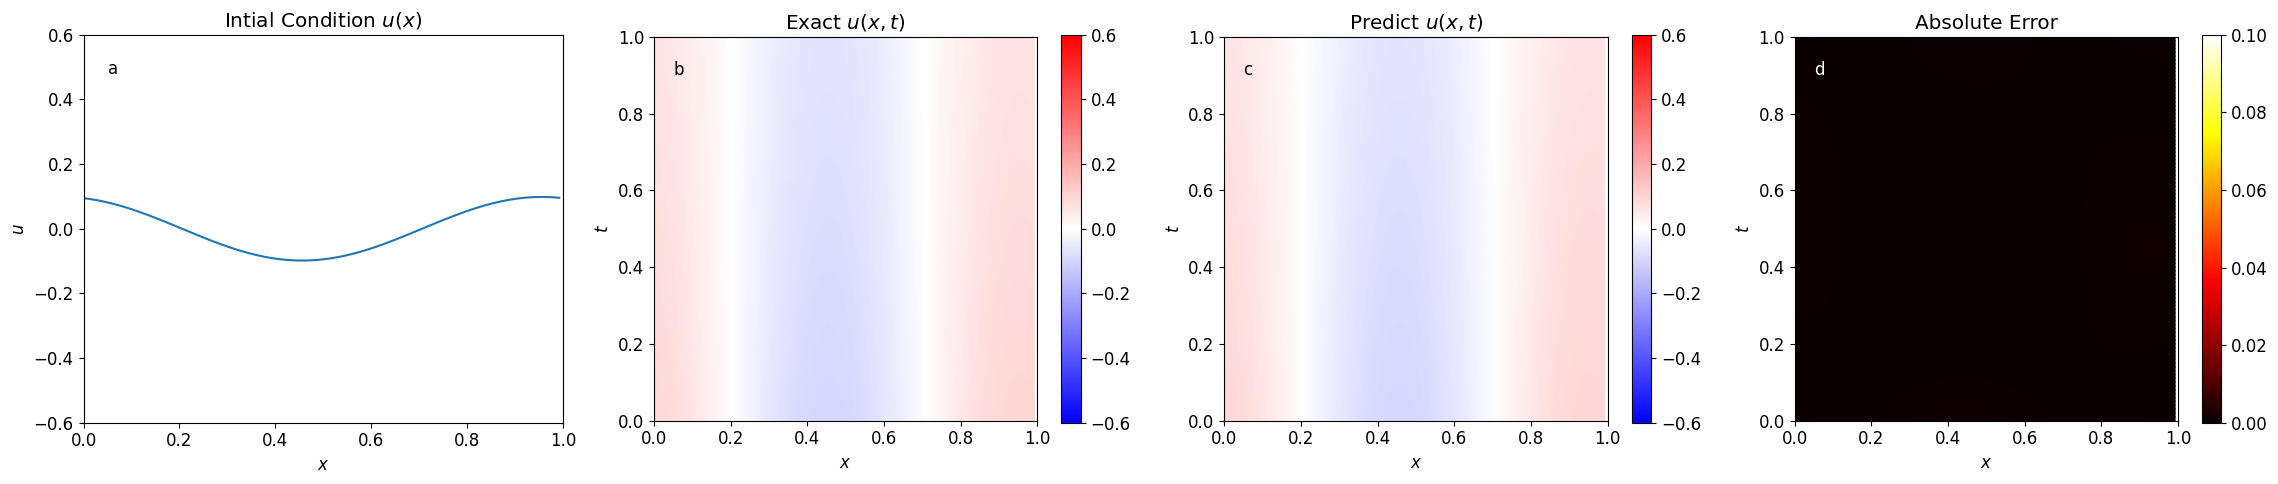

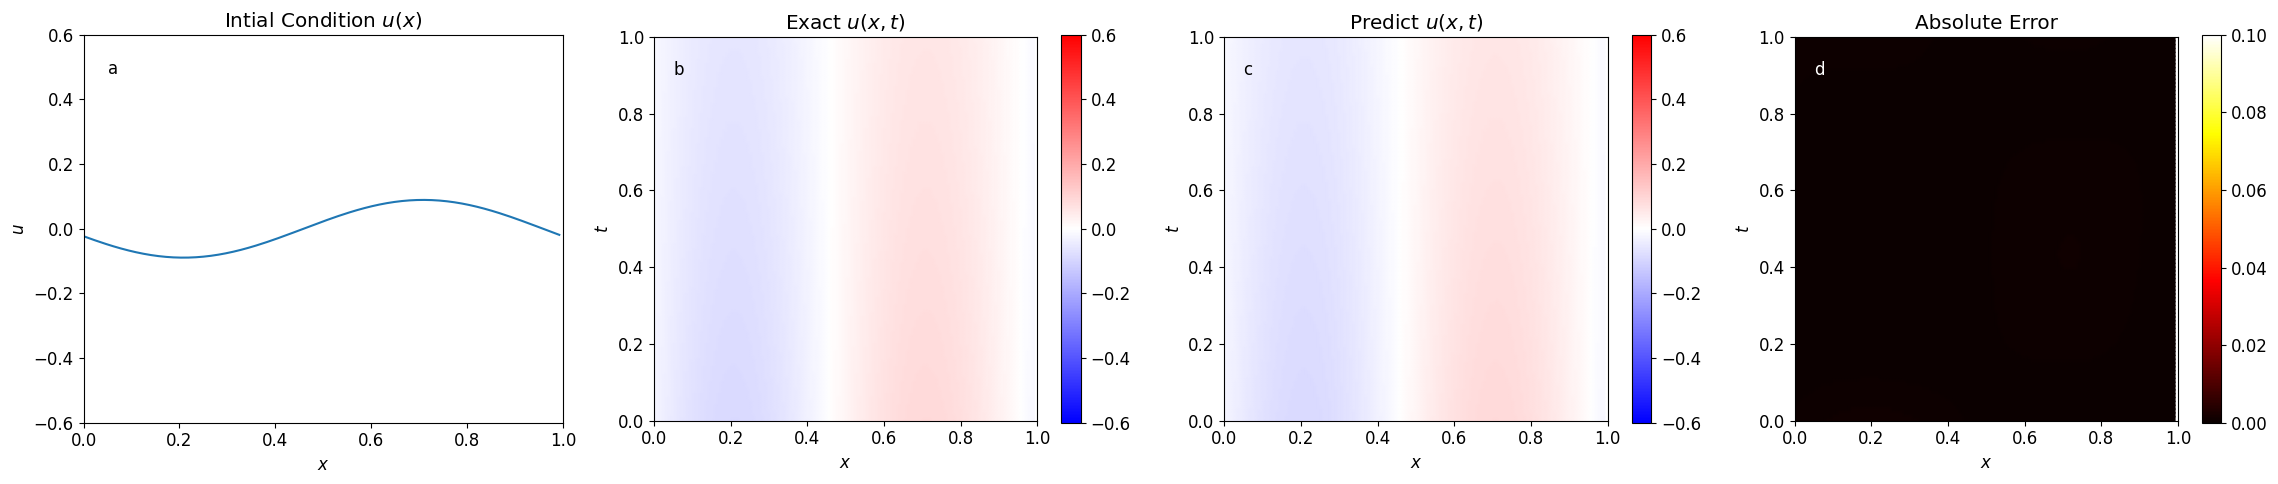

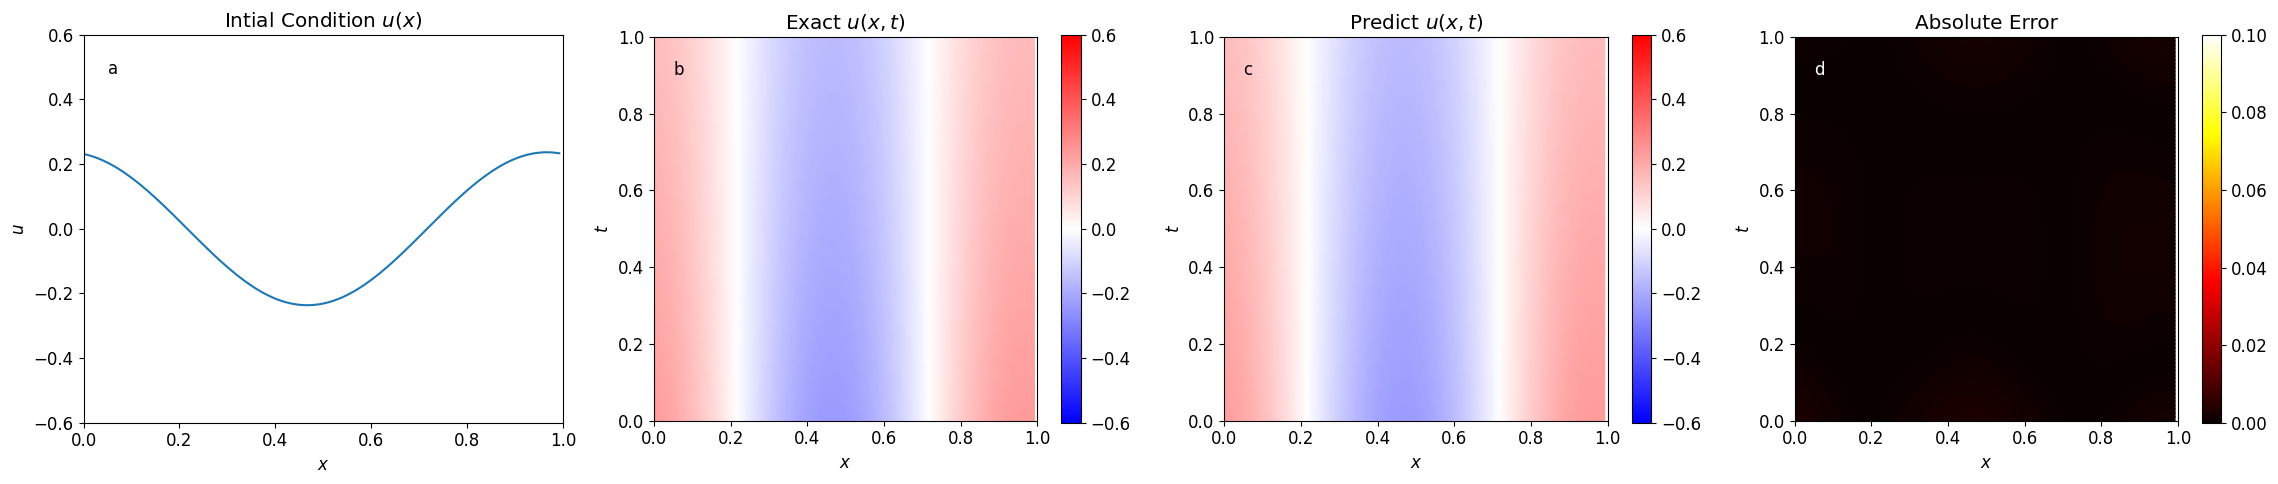

In [ ]:
%matplotlib inline
figures_dir = '../../Heat1D/HNO/figures/'
os.makedirs(figures_dir, exist_ok=True)
font_size = 12
for key in range(len(preds_y)):
    save_path = os.path.join(figures_dir, f'Heat1D_{key}')
    plot_predictions(key, test_x, test_y, preds_y, print_index=True, save_path=save_path, font_size=font_size)


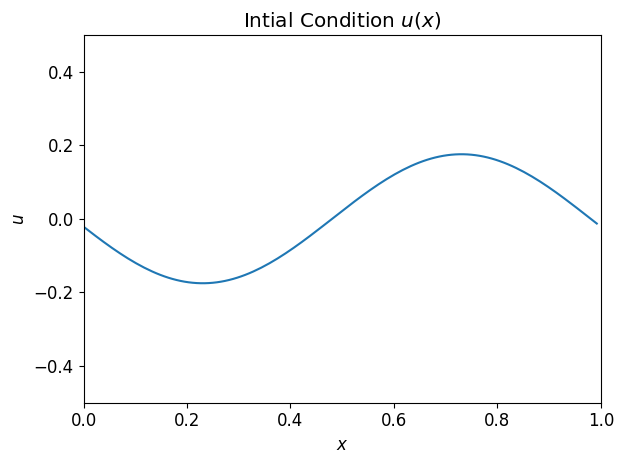

In [ ]:
plt.plot(x, u0)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Intial Condition $u(x)$')
plt.xlim([0,1])
plt.ylim([-0.5,0.5])
plt.tight_layout()

In [ ]:
def dht(x):
    X = np.fft.fft(x)
    X = X.real - X.imag
    return X

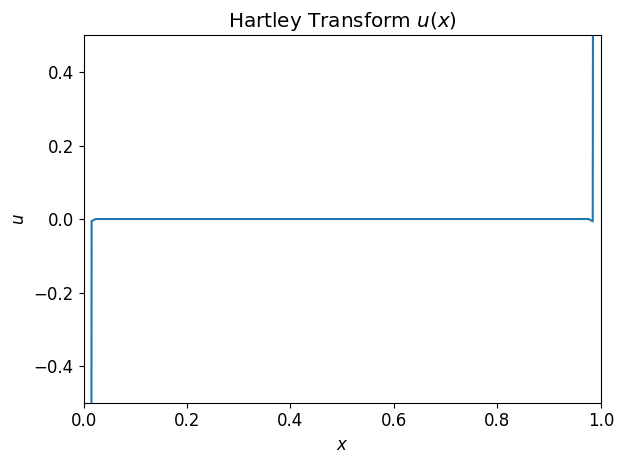

In [ ]:
plt.plot(x, dht(u0))
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Hartley Transform $u(x)$')
plt.xlim([0,1])
plt.ylim([-0.5,0.5])
plt.tight_layout()

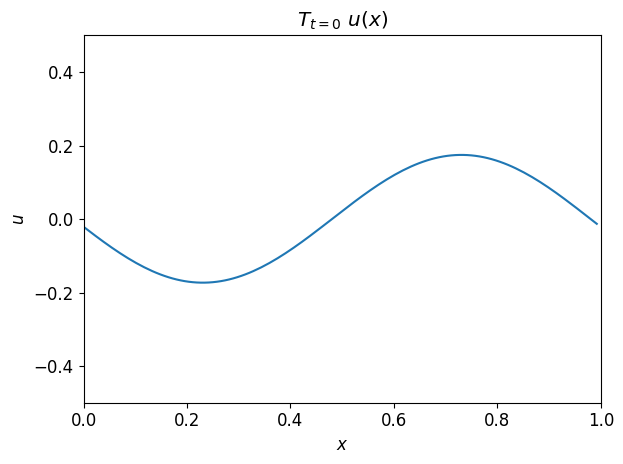

In [ ]:
plt.plot(X[0], pred[0])
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('$T_{t=0}$ $u(x)$')
plt.xlim([0,1])
plt.ylim([-0.5,0.5])
plt.tight_layout()

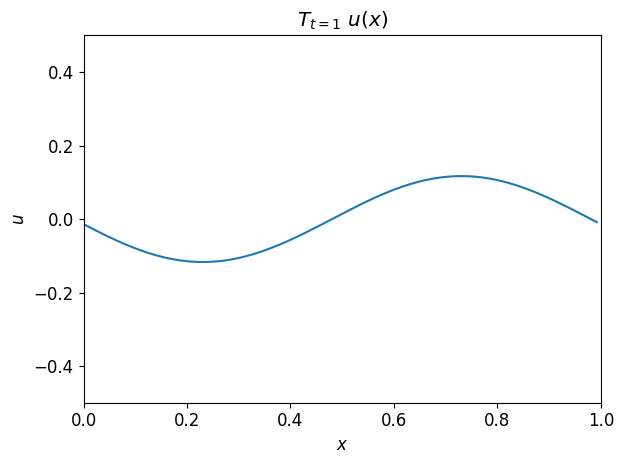

In [ ]:
plt.plot(X[-1], pred[-1])
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('$T_{t=1}$ $u(x)$')
plt.xlim([0,1])
plt.ylim([-0.5,0.5])
plt.tight_layout()